In [15]:
# import os
# from array import array
import numpy as np
# from commpy.filters import rcosfilter
# from commpy.filters import rrcosfilter
# import matplotlib
import matplotlib.pyplot as plt
# import ipympl
# #%matplotlib inline
# %matplotlib widget
import dsp_lib

In [16]:
# !pip install matplotlib
# !pip install scikit-commpy
# !pip install ipympl

In [17]:
def calculate_spectrum(signal):
    yf = np.fft.fft(signal)
    yf = np.abs(yf.reshape((len(yf), 1))) / len(signal)
    return yf


def plot_spectrum(signal, figure_counter, title="Amplitude spectrum"):
    spectrum = np.roll(calculate_spectrum(signal), len(signal) // 2)
    yf = 20 * np.log10(spectrum)

    plt.figure(figure_counter)
    plt.cla()
    x_data = np.arange(-len(spectrum) // 2 + 1, len(spectrum) // 2 + 1)
    x_data = x_data / (len(spectrum) / 2)
    plt.plot(x_data, yf)
    plt.grid(1)
    plt.xlabel('Frequency (semicircles)')
    plt.ylabel('Magnitude (dB)')
    plt.title(title)
    plt.show()
    return yf

def plot_signal_power(signal, figure_counter, title="Signal Power"):
    plt.figure(figure_counter)
    plt.cla()
    x_data = np.arange(0, len(signal))
    plt.plot(x_data, signal)
    plt.grid(1)
    plt.xlabel('time (samples)')
    plt.ylabel('Signal Power')
    plt.title(title)
    plt.show()
    
# def make_cmplx_sig(iq_data):
#     i = np.array(iq_data[:: 2])
#     i = i.reshape((len(i), 1))
#     q = np.array(iq_data[1:: 2])
#     q = q.reshape((len(q), 1))
#     print(i[:10])
#     sig = np.empty((len(i), 1), complex)
#     sig.real = i
#     sig.imag = q
#     sig_flatten = sig.flatten()
#     return sig_flatten

In [18]:
def read_float_by_unpack_delimeter(file_name, data_type, data_num=0, shift=0, separator='\n'):
    # Load test data
    
    #f = open(file_name,'rb')
    file_stats = os.stat(file_name)
    file_size = file_stats.st_size
    #print(file_size)
    if data_num == 0:
        if data_type == 'float32':
            data_num = int(file_size / 4)
        if data_type == 'int16':
            data_num = int(file_size / 2)
        if data_type == 'float64':
            data_num = int(file_size / 8)

    if data_type == 'float32':
        t = np.float32
    if data_type == 'int16':
        t = np.int16
    if data_type == 'float64':
        t = np.float64
    
    
    # Open the binary file using a file object
    print("data num")
    print(data_num)
    print(t)
    
    with open(file_name, 'rb') as file:
    # Read the binary data and convert it to a NumPy array
        data = np.fromfile(file, dtype=t, count=data_num, offset=shift, sep=separator)

    #with open(file_name, 'rb') as f:
     #   for line in f.readlines():
            # Each line represents a binary float, strip the newline and unpack
      #      number = struct.unpack('f', line.strip())[0]
       #     data_raw[i] = number
    
    #print("data num ")
    #print(data_num)
    #  102500 is the number of numbers contained in the document, and a floating point number occupies 4 bytes
    #arr = f.read(data_num * 4)
    #data_raw = struct.unpack('f'*data_num, arr)
    
    return data

In [19]:
# def gen_rrc_filter_impulse_response(n, f_sampl, t_symb, roll_off=0.24):
#     assert (n % 2 == 1), "RRC filter length should be odd!"
#     n += 1 # because first sample will be not used
#     s_psf = rrcosfilter(n * f_sampl, roll_off, Ts=t_symb, Fs=f_sampl)[1][1:]
#     return s_psf
# #%%
# def gen_rc_filter_impulse_response(n, f_sampl, t_symb, roll_off=0.24):
#     assert (n % 2 == 1), "RC filter length should be odd!"
#     n += 1 # because first sample will be not used
#     s_psf = rcosfilter(n * f_sampl, roll_off, Ts=t_symb, Fs=f_sampl)[1][1:]
#     return s_psf

In [20]:
def save_cmplx_sig(signal, filename, data_type='int16'):
    sig = np.round(signal)
    s_re = signal.real
    s_im = signal.imag
    if data_type == 'int16':
        arr_to_type_re = s_re.astype(np.int16)
        arr_to_type_im = s_im.astype(np.int16)
        arr_int = np.empty(len(signal) * 2, dtype=int)
    if data_type == 'float32':
        arr_to_type_re = s_re.astype(np.float32)
        arr_to_type_im = s_im.astype(np.float32)
        arr_int = np.empty(len(signal) * 2, dtype=float)
    if data_type == 'float64':
        arr_to_type_re = s_re.astype(np.float64)
        arr_to_type_im = s_im.astype(np.float64)
        arr_int = np.empty(len(signal) * 2, dtype=np.float64)

    print(len(arr_int))
    arr_int[ : : 2] = arr_to_type_re
    arr_int[1 : : 2] = arr_to_type_im
    if data_type == 'int16':
        saved_arr = arr_int.astype(np.int16)
    if data_type == 'float32':
        saved_arr = arr_int.astype(np.float32)
    if data_type == 'float64':
        saved_arr = arr_int.astype(np.float64)
        
    print(saved_arr[:30])
    with open(filename, 'wb') as f:
        saved_arr.tofile(f)

def upscale_to_i16(signal):
    max_i16 = 32767
    print(max(signal))
    print(max(signal.real))
    print(max(signal.imag))
    coeff = max_i16 / max(max(signal.real), max(signal.imag))
    print(coeff)
    return signal * np.floor(coeff)

def downscale_to_i16(signal):
    max_i16 = 32767
    print(max(signal))
    print(max(signal.real))
    print(max(signal.imag))
    coeff = max_i16 / max(max(signal.real), max(signal.imag))
    print(coeff)
    return signal * (coeff)

In [21]:
file_path = "qpsk_rrc_float64.bin"
data_type = 'float64'

source_samples = dsp_lib.read_signal(file_path, data_type, 0, 0, '')


data num
2064000
<class 'numpy.float64'>


[[-17445.56218344]
 [ -5890.83372494]
 [   723.86794084]
 [-17195.95802093]
 [-18866.46495783]
 [ -1064.98616395]
 [ -8675.21335857]
 [-23744.33947653]
 [ -7503.9904112 ]
 [  4357.73935062]]
[[-17445.56218344]
 [ -5890.83372494]
 [   723.86794084]
 [-17195.95802093]
 [-18866.46495783]
 [ -1064.98616395]
 [ -8675.21335857]
 [-23744.33947653]
 [ -7503.9904112 ]
 [  4357.73935062]]


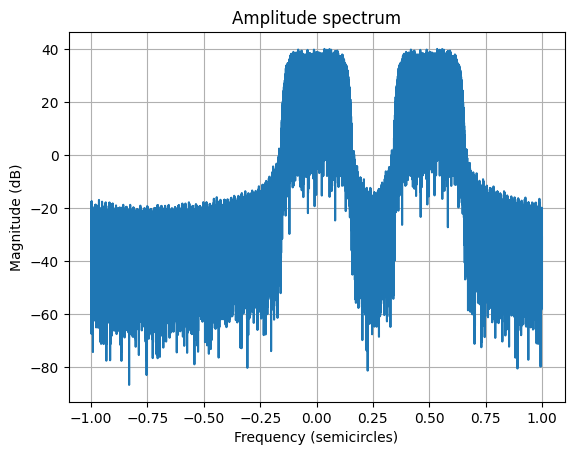

array([[-29.17792605],
       [-33.17467093],
       [-29.81961119],
       ...,
       [-34.30305442],
       [-29.7219693 ],
       [-31.02975485]])

In [22]:

dsp_lib.sum_double_val(8, 9)
dsp_lib.make_cmplx_sig(source_samples)

sig = dsp_lib.make_cmplx_sig(source_samples)
plot_spectrum(sig, 0)

In [23]:
N = 129#100
Fs = 1
T_symb = 8#1 / sig_board
s_rrc = dsp_lib.gen_rrc_filter_impulse_response(N, Fs, T_symb)


[-70984.99256232-80874.00788011j -66243.09878342-71567.77580243j
 -60010.11756228-60755.85769044j -52552.78290305-49388.73546126j
 -44361.754848  -38187.35398484j -36042.81977936-27887.04974186j
 -27996.51345233-19081.17029281j -20544.58266894-11993.73220361j
 -14027.12116333 -6681.49537017j  -8592.59877874 -3078.54191481j]


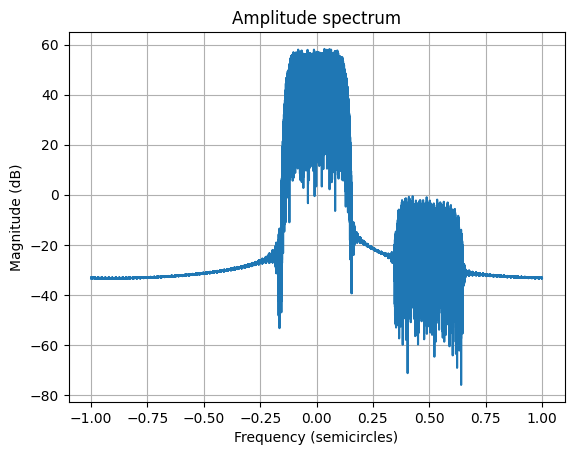

2064000
[-50075.42116784  24708.35862616 -65652.79434878  22309.92245555
 -79955.1716023   16652.17367878 -91209.28523494   7959.6190125
 -97950.01166038  -3112.35455993 -99044.22467428 -15829.06037004
 -93638.21689564 -29237.35872826 -81596.46397095 -42115.75052012
 -63694.12832671 -53444.44906122 -41263.57847544 -62581.08832304
 -16110.11317601 -69009.82375699   9327.68828082 -72470.02568431
  32359.43119833 -73292.18509634  50659.28718654 -72194.28234593
  62415.26414386 -69889.35844021]


In [24]:
sig_rrc = np.convolve(sig, s_rrc, 'same')
print(sig_rrc[len(sig_rrc) - 10:])
plot_spectrum(sig_rrc, 1)
save_cmplx_sig(sig_rrc, "qpsk_rrc_after_py_rrc_fl64.bin", 'float64')

[-70985.01 -80874.01j   -66243.1  -71567.78j   -60010.12 -60755.855j
 -52552.78 -49388.734j  -44361.758-38187.355j  -36042.82 -27887.05j
 -27996.51 -19081.172j  -20544.584-11993.731j  -14027.121 -6681.495j
  -8592.598 -3078.5415j]
2064000
[-50075.418   24708.36   -65652.8     22309.924  -79955.17    16652.17
 -91209.29     7959.6216 -97950.016   -3112.3552 -99044.23   -15829.064
 -93638.22   -29237.357  -81596.46   -42115.75   -63694.13   -53444.457
 -41263.58   -62581.09   -16110.115  -69009.83     9327.688  -72470.03
  32359.434  -73292.19    50659.29   -72194.29    62415.26   -69889.36  ]


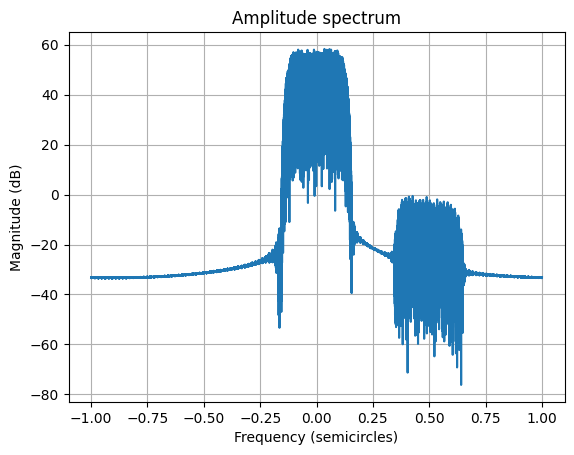

[-0.00527526 -0.00399103 -0.00164843  0.00129551]
[-0.00527526 -0.00399103 -0.00164843  0.00129551]
<class 'numpy.float64'>
9.253751671184363e-11


In [25]:
sig_fl32 = np.array(sig,  dtype=np.csingle)
s_rrc_fl32 = np.array(s_rrc, dtype = np.float32)
sig_rrc_fl32 = np.convolve(sig_fl32, s_rrc_fl32, 'same')
print(sig_rrc_fl32[len(sig_rrc_fl32) - 10:])
save_cmplx_sig(sig_rrc_fl32, "qpsk_rrc_after_py_rrc_fl32.bin", data_type='float32')
plot_spectrum(sig_rrc_fl32, 2)
print(s_rrc[:4])
print(s_rrc_fl32[:4])
print(type(s_rrc[0]))
print(s_rrc[0] - s_rrc_fl32[0])

In [26]:
sig_rrc_scaled = downscale_to_i16(sig_rrc)
max(sig_rrc_scaled)

(120065.13706716806+51633.101557996466j)
120065.13706716806
119579.56030294044
0.27291019525234167


np.complex128(32767+14091.199827676803j)

In [27]:
max(sig_rrc)

np.complex128(120065.13706716806+51633.101557996466j)

In [28]:
sig_rrc[-10:]

array([-70984.99256232-80874.00788011j, -66243.09878342-71567.77580243j,
       -60010.11756228-60755.85769044j, -52552.78290305-49388.73546126j,
       -44361.754848  -38187.35398484j, -36042.81977936-27887.04974186j,
       -27996.51345233-19081.17029281j, -20544.58266894-11993.73220361j,
       -14027.12116333 -6681.49537017j,  -8592.59877874 -3078.54191481j])